In [20]:
import random
import os

import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator


from typing import Callable, List, Union


from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.eda.auto as auto #EDA
from IPython.display import Image, display
 
pd.set_option('display.max_seq_items', None)

In [21]:

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

In [22]:
seed_everything(42) # Seed 고정

train_d = pd.read_csv("../input/train.csv")
test_d = pd.read_csv("../input/test.csv")

train_plas= pd.read_csv("../input/train_out.csv")
test_plas = pd.read_csv("../input/test_out.csv")

In [23]:

#torch custom dataset 인데, 정의만 하고 사용하지 않았어요
class CustomDataset(Dataset):
    def __init__(self, df, target, is_test=False):
        self.df      = df
        self.target  = target # HLM or MLM
        self.feature = self.df[['AlogP', 'Molecular_Weight', 'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD', 'Molecular_PolarSurfaceArea', 'plas']].values 
        self.label   = self.df[self.target].values

        self.is_test = is_test # train,valid / test

    def __getitem__(self, index):
        feature = self.feature[index]
        label = self.label[index]

        if not self.is_test: # test가 아닌 경우(label 존재)
            return torch.tensor(feature, dtype=torch.float), torch.tensor(label, dtype=torch.float).unsqueeze(dim=-1) # feature, label
        else: # test인 경우
            return torch.tensor(feature, dtype=torch.float).float() # feature
        
    def __len__(self):
        return len(self.df)

In [24]:
def morgan_binary_features_generator(mol: Union[str, Chem.Mol], plot_img = False,
                                     radius: int = 2,
                                     num_bits: int = 32) -> np.ndarray:
    
    mol = Chem.MolFromSmiles(mol) if type(mol) == str else mol
    if plot_img:
        display(mol)
    features_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=num_bits)
    features = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(features_vec, features)
    return features

In [25]:
def makeFPsAsLongNumberStr(mol: Union[str, Chem.Mol]):
    fps = morgan_binary_features_generator(mol)
    return ''.join([str(int(i)) for i in fps])

In [26]:
chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v',
                          'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
                          'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3',
                          'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge',
                          'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount',
                          'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
                          'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
                          'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
                          'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8',
                          'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6',
                          'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5'
                         ]

np.float = float  # to avoid "module 'numpy' has no attribute 'float'"
def getDescriptorValues(mol: Union[str, Chem.Mol]):

    mol = Chem.MolFromSmiles(mol) if type(mol) == str else mol
    mol_descriptor_calculator = MolecularDescriptorCalculator(chosen_descriptors)
    # use molecular descriptor calculator on RDKit mol object
    descriptor_vals = list(mol_descriptor_calculator.CalcDescriptors(mol))

    return descriptor_vals

In [27]:
# FPs column 추가
train_d["plas"] = train_plas["pred_0"]
test_d["plas"] = test_plas["pred_0"]

# FPS 정보 추가
train_d["FPS"]= train_d["SMILES"].apply(makeFPsAsLongNumberStr)
test_d["FPS"]=  test_d["SMILES"].apply(makeFPsAsLongNumberStr)

# descriptor 정보 추가
train_d["add"] = train_d["SMILES"].apply(lambda x: getDescriptorValues(x)) # new feautre as descriptor
train_d[chosen_descriptors] = pd.DataFrame(train_d["add"].tolist())
train_d.drop(["add"], axis=1, inplace=True)

test_d["add"] = test_d["SMILES"].apply(lambda x: getDescriptorValues(x)) # new feautre as descriptor
test_d[chosen_descriptors] = pd.DataFrame(test_d["add"].tolist())
test_d.drop(["add"], axis=1, inplace=True)

for key in chosen_descriptors:
    if ( len(train_d[key].unique()) < (len(train_d)//3)):
        print(f"Drop the Calculated Feautre: {key}")
        train_d.drop([key], axis=1, inplace=True)
        test_d.drop([key], axis=1, inplace=True)


train_d["AlogP"].fillna(value=train_d["AlogP"].mean(), inplace=True)
test_d["AlogP"].fillna(value=train_d["AlogP"].mean(), inplace=True)

train_d.fillna(value=0, inplace=True)
test_d.fillna(value=0, inplace=True)


print(train_d.head(3))
print(test_d.head(3))

Drop the Calculated Feautre: EState_VSA1
Drop the Calculated Feautre: EState_VSA10
Drop the Calculated Feautre: EState_VSA11
Drop the Calculated Feautre: EState_VSA5
Drop the Calculated Feautre: EState_VSA6
Drop the Calculated Feautre: EState_VSA7
Drop the Calculated Feautre: EState_VSA9
Drop the Calculated Feautre: FpDensityMorgan1
Drop the Calculated Feautre: FpDensityMorgan2
Drop the Calculated Feautre: FpDensityMorgan3
Drop the Calculated Feautre: FractionCSP3
Drop the Calculated Feautre: HeavyAtomCount
Drop the Calculated Feautre: NHOHCount
Drop the Calculated Feautre: NOCount
Drop the Calculated Feautre: NumAliphaticCarbocycles
Drop the Calculated Feautre: NumAliphaticHeterocycles
Drop the Calculated Feautre: NumAliphaticRings
Drop the Calculated Feautre: NumAromaticCarbocycles
Drop the Calculated Feautre: NumAromaticHeterocycles
Drop the Calculated Feautre: NumAromaticRings
Drop the Calculated Feautre: NumHAcceptors
Drop the Calculated Feautre: NumHDonors
Drop the Calculated Fea

train colums: 65
test colums: 63


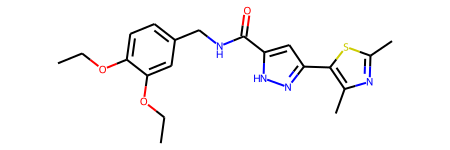

Tester to FPs: [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1.]
Unique len: 3391 / 3498


In [28]:
print(f"train colums: {len(train_d.columns)}")
print(f"test colums: {len(test_d.columns)}")


# Show Sampled Mol from SMILES data
print(f"Tester to FPs: {morgan_binary_features_generator(train_d['SMILES'][0], True)}")
print(f"Unique len: {train_d['FPS'].unique().shape[0]} / {train_d.shape[0]}")

In [29]:
train_d.isna().sum(), test_d.isna().sum()

(id              0
 SMILES          0
 MLM             0
 HLM             0
 AlogP           0
                ..
 VSA_EState10    0
 VSA_EState2     0
 VSA_EState3     0
 VSA_EState4     0
 VSA_EState5     0
 Length: 65, dtype: int64,
 id                  0
 SMILES              0
 AlogP               0
 Molecular_Weight    0
 Num_H_Acceptors     0
                    ..
 VSA_EState10        0
 VSA_EState2         0
 VSA_EState3         0
 VSA_EState4         0
 VSA_EState5         0
 Length: 63, dtype: int64)

In [30]:
# 사용할 column만 추출
train_MLM = TabularDataset(train_d.drop(['id', "HLM"], axis=1))
train_HLM = TabularDataset(train_d.drop(['id', "MLM"], axis=1))
test = TabularDataset(test_d.drop(["id"], axis=1))

No path specified. Models will be saved in: "AutogluonModels/ag-20230907_085832/"


### Model Prediction for MLM

Using validation data for `Test` points

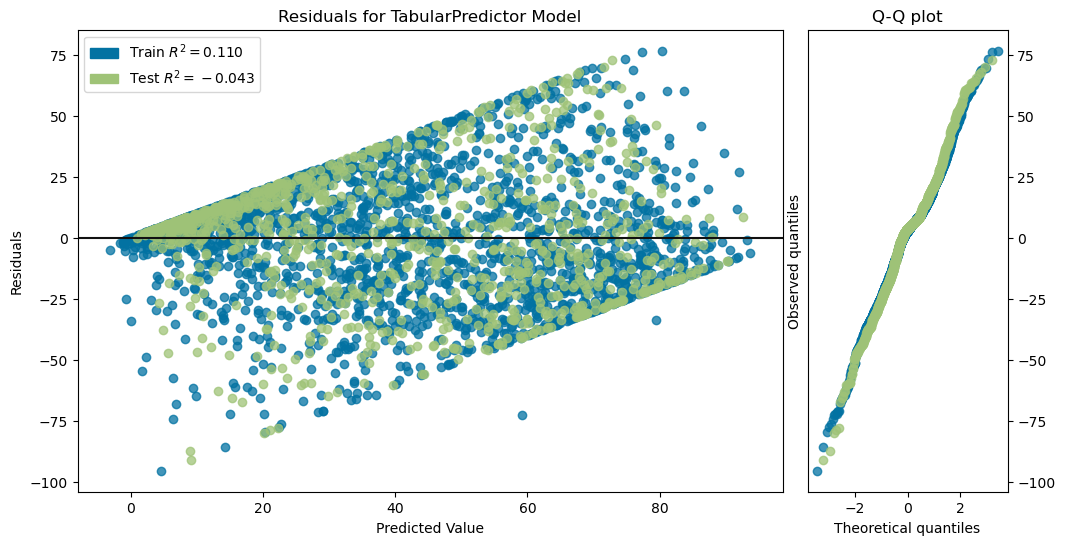

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-24.971034,-23.707188,0.029602,0.021715,2.544412,0.029602,0.021715,2.544412,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
HLM,15.461872,0.268877,1.096912e-08,5,16.015493,14.908251
LogD,0.240973,0.060291,4.334271e-04,5,0.365114,0.116833
VSA_EState3,0.146135,0.054637,1.964318e-03,5,0.258634,0.033637
MolLogP,0.142674,0.070873,5.405450e-03,5,0.288603,-0.003255
AlogP,0.098864,0.034575,1.535948e-03,5,0.170054,0.027674
VSA_EState5,0.090898,0.044837,5.275982e-03,5,0.183219,-0.001423
BalabanJ,0.064727,0.017109,5.349775e-04,5,0.099955,0.029499
Num_H_Donors,0.061989,0.028273,4.014439e-03,5,0.120204,0.003775
HeavyAtomMolWt,0.056597,0.027055,4.732133e-03,5,0.112305,0.000890
VSA_EState2,0.053920,0.012704,3.438765e-04,5,0.080077,0.027763


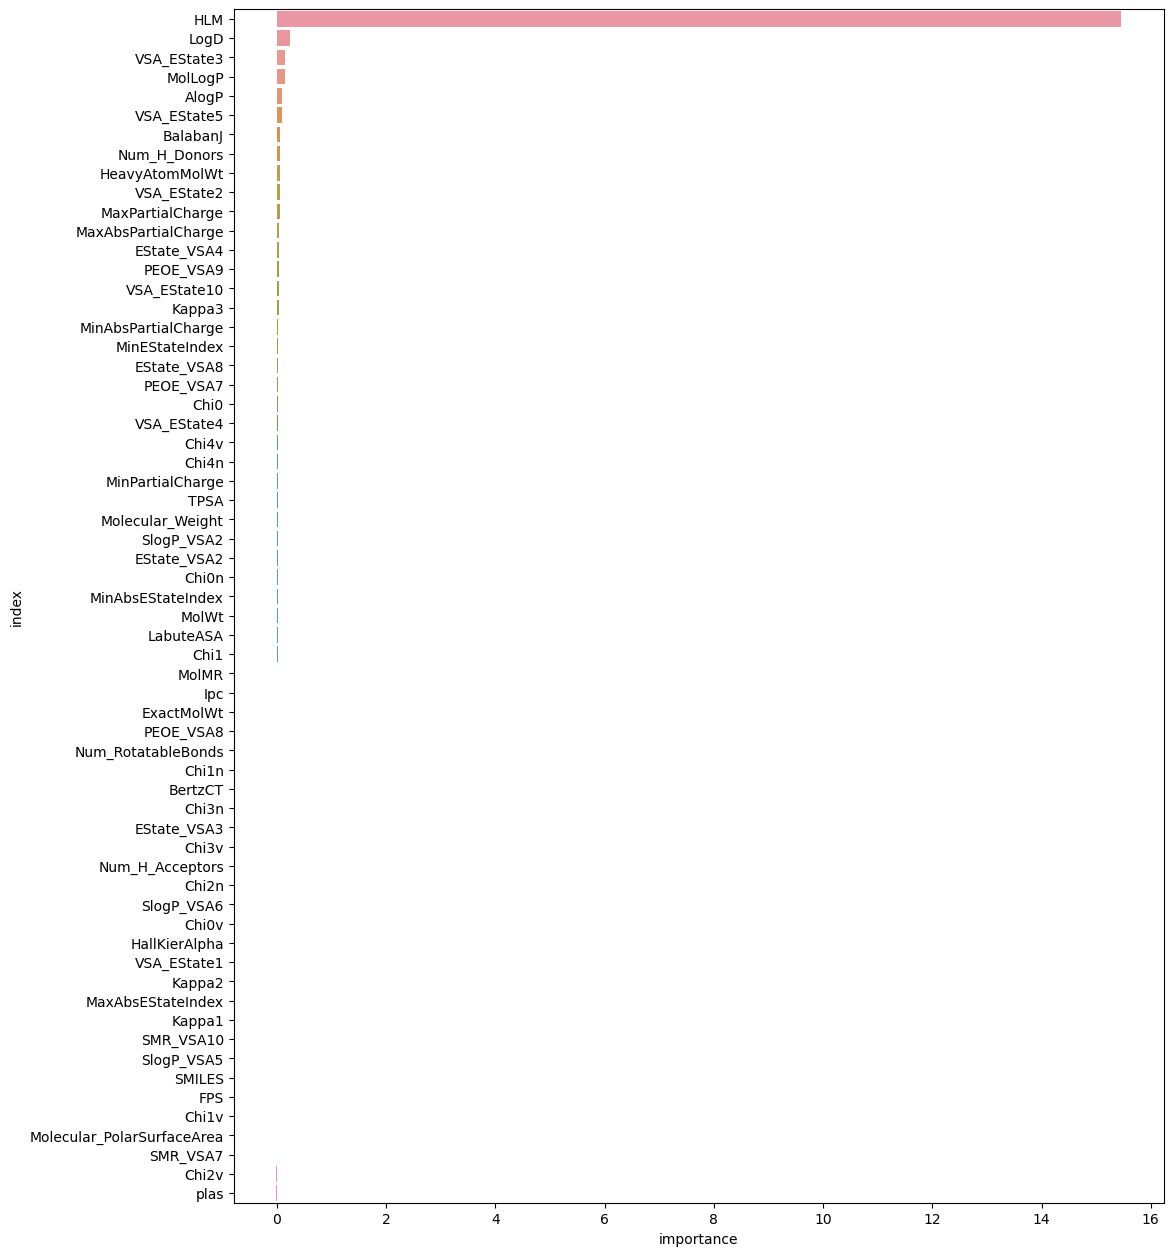

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,id,SMILES,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,...,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,MLM,MLM_pred,error
2478,TRAIN_2478,Cc1nc2ccc(N3CCN(c4ncc(C)s4)CC3)nn2n1,4.040,1.587,315.397,4,0,2,1.587,90.68,...,62.45,1.612328,1.754216,14.658354,9.960047,0.789951,1.695350,99.990,9.123246,90.866754
2245,TRAIN_2245,CCc1nc2cc(Br)c(C(=O)OC)nc2n1CC(=O)c1ccccc1,1.340,3.815,402.242,5,0,6,3.819,74.08,...,74.08,7.022816,3.322598,33.405207,0.000000,1.893185,0.146845,96.170,8.894303,87.275697
2306,TRAIN_2306,Cc1cc(-c2cnc(C)nc2-c2sccc2C)on1,63.430,2.939,271.338,3,0,2,2.952,80.05,...,51.81,5.343421,1.674627,9.992044,6.000128,3.859179,1.461192,99.990,20.147255,79.842745
1654,TRAIN_1654,CC(=O)c1c(NC2CCCc3ccccc32)[nH]c2c(-c3ccccc3)cccc2c1=O,35.901,5.233,408.492,2,2,4,5.233,58.20,...,61.96,0.000000,0.000000,29.324459,4.051111,5.233007,0.273095,99.900,21.101076,78.798924
2743,TRAIN_2743,Cc1cc2cc(NC(=O)c3cc4nccc(-c5cnn(C)c5C)n4n3)cc(Cl)c2o1,18.820,3.172,420.852,4,1,3,3.172,90.25,...,90.25,9.009554,6.291935,17.188932,12.869563,4.695381,0.393536,99.990,22.187490,77.802510
2583,TRAIN_2583,COCCCn1cnnc1C(C)NC(=O)c1cnn[nH]1,80.404,-0.932,279.298,6,2,7,-0.932,110.61,...,110.61,6.910066,0.000000,11.883255,20.312921,0.307684,0.412842,0.000,72.766960,72.766960
1275,TRAIN_1275,CN(C)C(=O)COCC(=O)Nc1ccc(C#N)cc1,86.442,-0.169,261.276,4,1,5,-0.169,82.43,...,82.43,4.980040,0.000000,24.071436,11.227983,1.094782,-0.553299,1.794,71.592628,69.798628
1051,TRAIN_1051,Cc1ccc2cc(CN(CCO)S(=O)(=O)c3ccc(C(C)(C)C)cc3)c(=O)[nH]c2c1C,99.990,3.746,442.571,4,2,7,3.746,95.09,...,90.47,27.677086,0.000000,15.742727,10.332931,3.738419,0.000000,0.090,67.862633,67.772633
3029,TRAIN_3029,O=C(NCCCCCCNC(=O)N1CCCCC1)N1CCCCC1,99.900,2.358,338.488,2,2,7,2.358,64.68,...,64.68,0.000000,0.000000,27.702837,6.030174,0.000000,0.000000,0.206,67.448212,67.242212
2751,TRAIN_2751,CCc1ccc(C2c3cccn3-c3sc4c(c3CN2C(=O)Nc2ccc(OC)c(OC)c2)CCCC4)cc1,15.400,7.241,527.677,3,1,5,7.241,83.97,...,55.73,13.184803,1.902644,17.625112,4.417248,6.897194,1.205991,83.950,16.738832,67.211168


In [31]:
# EDA
state = auto.quick_fit(
    train_d, 
    "MLM", 
    return_state=True,
    fit_bagging_folds=3,
    show_feature_importance_barplots=True
)

,id,SMILES,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,...,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,MLM,MLM_pred,error
2478,TRAIN_2478,Cc1nc2ccc(N3CCN(c4ncc(C)s4)CC3)nn2n1,4.04,1.587,315.397,4,0,2,1.587,90.68,...,62.45,1.612328,1.754216,14.658354,9.960047,0.789951,1.69535,99.99,9.123246,90.866754


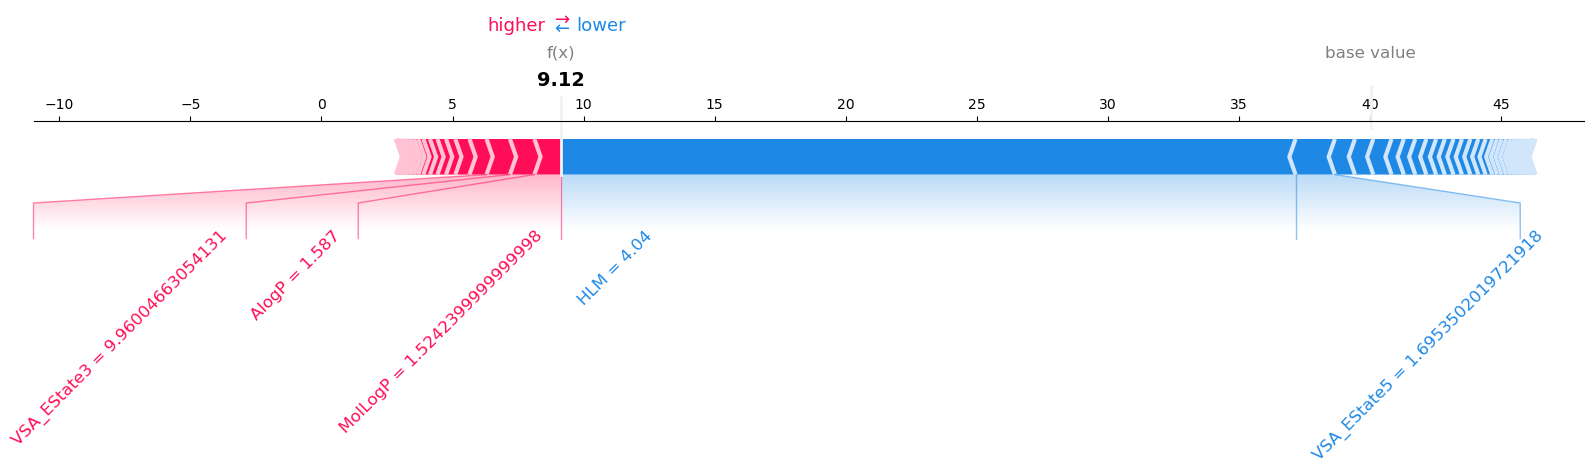

In [32]:
auto.explain_rows(
    train_data=train_d,
    model=state.model,
    display_rows=True,
    rows=state.model_evaluation.highest_error[:1]
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230907_085849/"


### Model Prediction for HLM

Using validation data for `Test` points

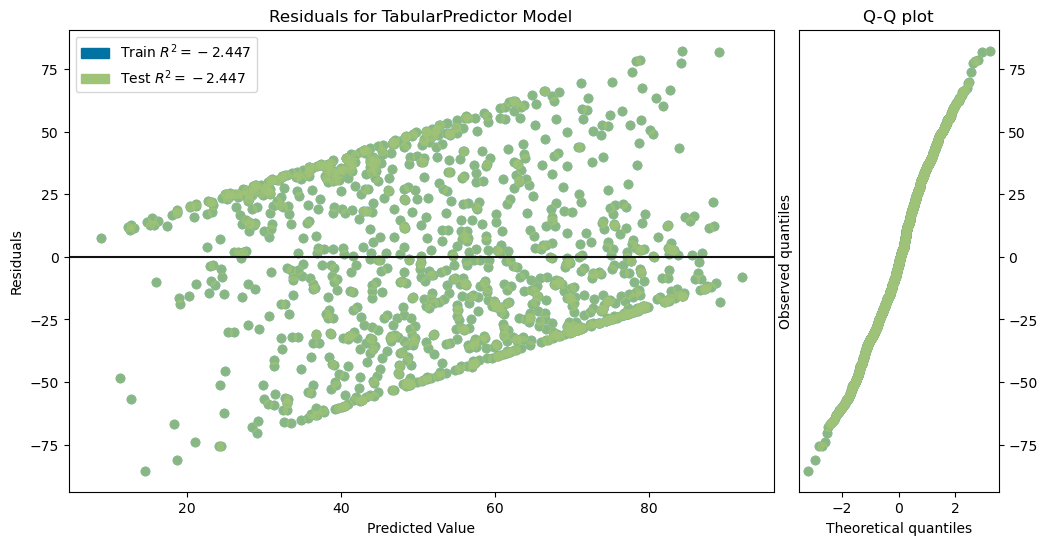

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-32.516168,-30.906881,0.011029,0.007239,1.212898,0.011029,0.007239,1.212898,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
LogD,1.402454,0.276912,0.000173,5,1.972619,0.832289
VSA_EState3,0.584713,0.076474,0.000034,5,0.742173,0.427252
AlogP,0.512515,0.136093,0.000544,5,0.792733,0.232298
Num_RotatableBonds,0.228825,0.094910,0.002863,5,0.424245,0.033404
MolLogP,0.158425,0.059504,0.001998,5,0.280945,0.035905
MaxAbsEStateIndex,0.152546,0.076908,0.005688,5,0.310899,-0.005808
VSA_EState5,0.105255,0.070196,0.014247,5,0.249790,-0.039280
VSA_EState2,0.090381,0.036301,0.002550,5,0.165125,0.015637
MaxAbsPartialCharge,0.088539,0.034302,0.002237,5,0.159168,0.017910
MinAbsPartialCharge,0.087881,0.048723,0.007846,5,0.188202,-0.012440


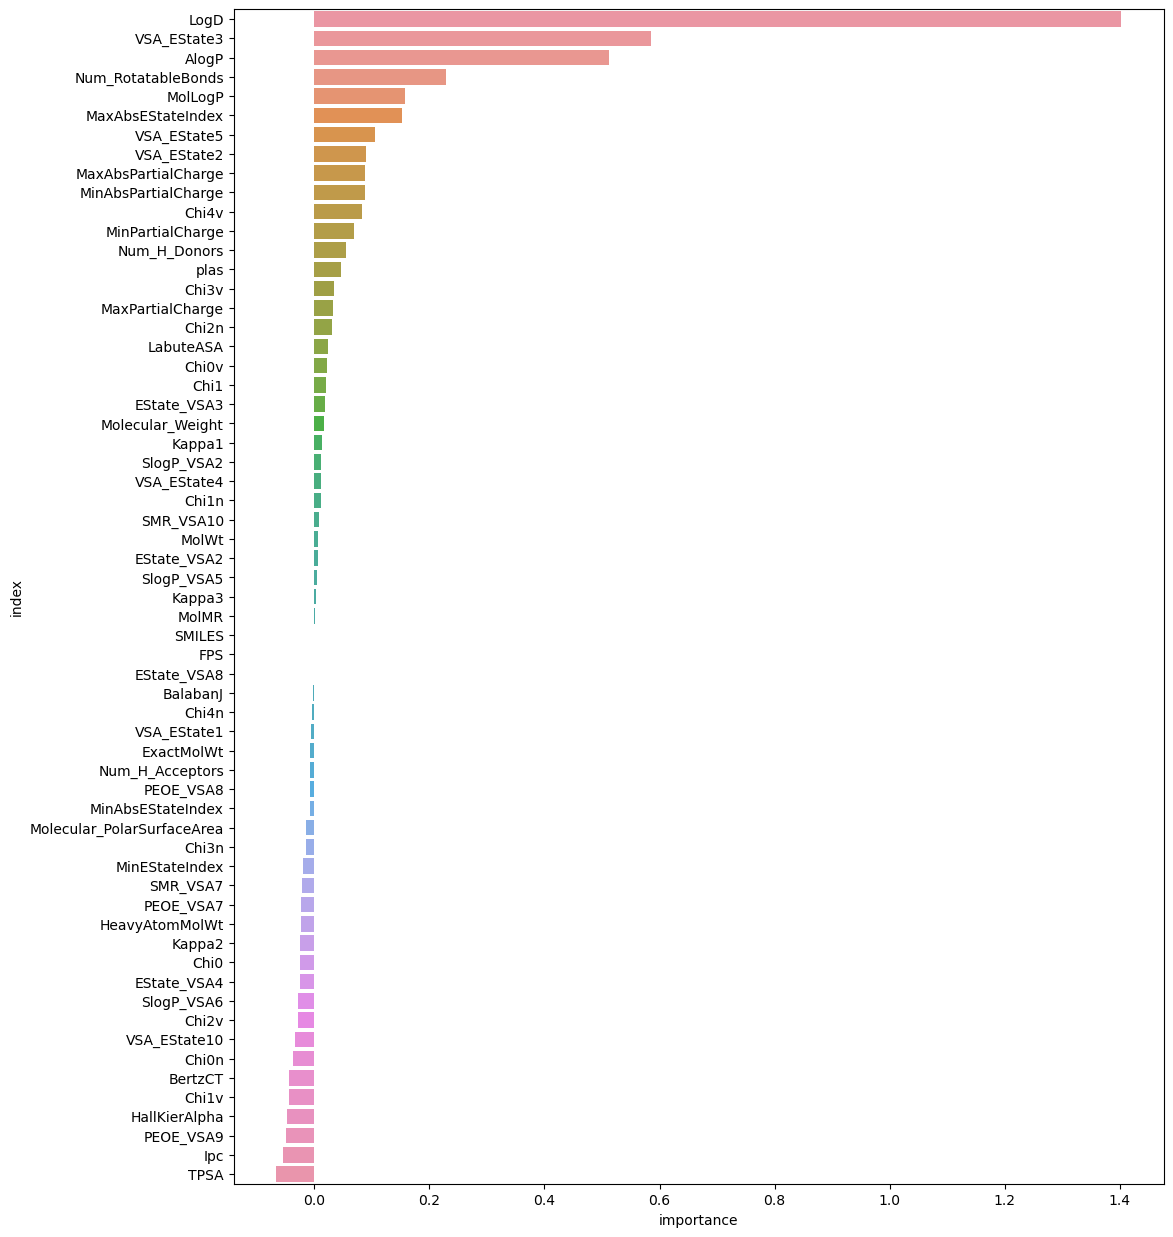

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,plas,FPS,...,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,HLM,HLM_pred,error
1160,[H][C@@]12CC[C@@H](C)O[C@@]1([H])c1c(OCC(=O)NC)cccc1O[C@@]2(C)CCCC(C)C,4.168,389.528,4,1,7,4.168,56.79,0.109174,11111001011011111110101101110111,...,56.79,18.922105,0.000000,11.665685,2.597522,0.718368,2.351203,99.990,14.522941,85.467059
3109,CCCNC(=O)NC(=O)CNC1(C(=O)OC(C)(C)C)CCCC1,1.606,327.419,5,3,8,0.380,96.53,0.261505,11011111111001101110010110110111,...,96.53,5.479077,0.000000,35.747453,7.815851,-1.401622,-0.792434,1.912,84.320709,82.408709
663,O=C(C1CCOCC1)N1CCC(Oc2nccnc2N2CCOCC2)C1,0.105,362.423,6,0,4,0.105,77.02,0.004593,11111111101111111100011101110111,...,77.02,16.920797,0.000000,25.608248,0.000000,0.000000,1.666340,7.200,89.030151,81.830151
137,CCc1cc2c3c([nH]c2cc1S(=O)(=O)N(Cc1ccccc1)C(C)C)CCCC3=O,4.884,424.556,3,1,6,4.884,78.62,0.514715,11101111111101111101101101111010,...,70.24,29.060604,0.000000,16.147662,0.851534,4.118903,0.146338,99.900,18.705070,81.194930
2590,COCc1nc(CCNS(=O)(=O)c2cccc(OC)c2)no1,0.211,327.356,6,1,8,0.219,111.93,0.246050,11111011011101011111111110111111,...,103.55,41.570542,0.000000,4.201002,3.733563,0.000000,1.248885,0.000,78.841919,78.841919
2313,Cc1nnc2c(N3CCN(C(=O)c4n[nH]c5c4CCCC5)CC3)nccn12,1.268,366.420,5,1,2,1.268,95.31,0.014399,11111001111011110100111101100111,...,95.31,1.940346,0.000000,21.551071,15.787009,3.641616,1.700609,0.000,78.291054,78.291054
3182,Nc1nc(F)c2ncn(C3CC(O)C(CO)O3)c2n1,-0.546,269.232,6,3,2,-0.508,119.31,0.255084,11101001110010001101100111111011,...,119.31,20.451665,0.000000,11.164739,18.726907,5.579738,-1.011567,6.548,84.136589,77.588589
3477,Cc1cc(C)c(N(C)S(=O)(=O)c2ccc3c(c2)C(=O)Nc2ccc(C)cc2O3)c(C)c1,4.983,436.523,4,1,3,4.983,84.09,0.014381,11001100001110011111011111110111,...,75.71,34.029695,0.000000,12.840595,2.797466,5.123894,0.413781,99.990,24.211493,75.778507
3034,CC(Sc1nnnn1C(C)C)C(=O)C12CC3CC(CC(C3)C1)C2,3.571,334.480,5,0,5,3.571,85.97,0.276909,01011011001111011010100110110110,...,60.67,1.813622,1.539552,13.305347,12.650196,-0.030479,2.884312,99.900,24.411297,75.488703
1098,CC1CCc2cc(F)ccc2N1S(=O)(=O)c1ccc(S(=O)(=O)NC2CCCCC2)cc1,4.406,466.589,4,1,5,4.499,100.31,0.615442,11101111111111110101101100110111,...,83.55,69.870414,0.000000,0.054934,0.000000,1.118859,-0.397522,95.255,21.094652,74.160348


In [33]:
state = auto.quick_fit(
    train_HLM, 
    "HLM", 
    return_state=True,
    show_feature_importance_barplots=True
)

In [34]:
predictor_MLM = TabularPredictor(label='MLM', eval_metric='root_mean_squared_error', verbosity=False).fit(train_MLM)
predictor_HLM = TabularPredictor(label='HLM', eval_metric='root_mean_squared_error', verbosity=False).fit(train_HLM)

ld_board_MLM = predictor_MLM.leaderboard(train_MLM, silent=True)
print("="*20, "MLM", "="*20)
print(ld_board_MLM)
print(f"Best: {predictor_MLM.get_model_best()}")

ld_board_HLM = predictor_HLM.leaderboard(train_HLM, silent=True)
print("="*20, "HLM", "="*20)
print(ld_board_HLM)
print(f"Best: {predictor_HLM.get_model_best()}")

==================== MLM ====================
                  model  score_test  score_val  pred_time_test  pred_time_val  \
0         LightGBMLarge  -12.583234 -31.519910        0.087366       0.017486   
1        KNeighborsDist  -15.349924 -40.118839        0.058692       0.009212   
2         ExtraTreesMSE  -15.884399 -31.390089        0.158594       0.054072   
3       RandomForestMSE  -15.895373 -31.315420        0.181272       0.077247   
4               XGBoost  -17.911526 -31.890806        0.037740       0.008297   
5   WeightedEnsemble_L2  -22.969254 -30.487625        0.546205       0.163812   
6            LightGBMXT  -23.759762 -31.244916        0.043944       0.007535   
7              CatBoost  -24.486814 -31.294059        0.014307       0.005249   
8              LightGBM  -25.735511 -31.286524        0.013545       0.004284   
9       NeuralNetFastAI  -28.163507 -30.841579        0.079460       0.017129   
10       NeuralNetTorch  -30.832926 -33.826721        0.072344 

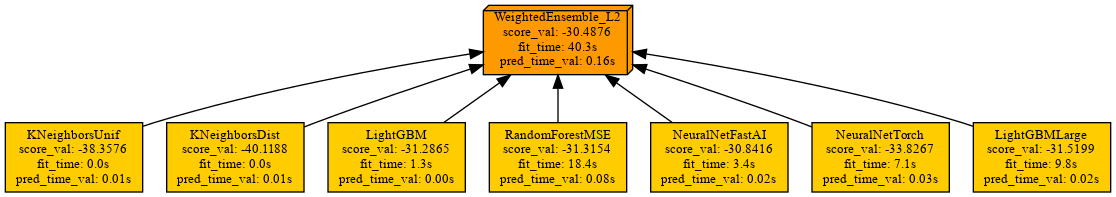

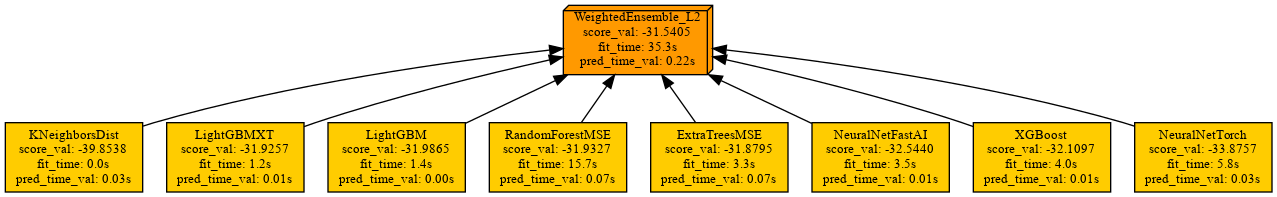

In [35]:
path_to_png=predictor_MLM.plot_ensemble_model()
display(Image(filename=path_to_png))
path_to_png=predictor_HLM.plot_ensemble_model()
display(Image(filename=path_to_png))

---

In [36]:
#### TESTING

In [37]:
# 결과파일 작성
pred_MLM = predictor_MLM.predict(test)
pred_HLM = predictor_HLM.predict(test)

submission = pd.DataFrame()
submission["id"] = test_d["id"]
submission["MLM"] = pred_MLM
submission["HLM"] = pred_HLM

submission.to_csv("../output/submission.csv", index=False)

In [38]:
# check before sub
submission.isna().sum()

id     0
MLM    0
HLM    0
dtype: int64